
# Packet Capture Traffic Analysis

Rubric-aligned workflow for comparing idle, Zoom, YouTube, and Netflix traces generated via `packet_analyzer.py`.


In [2]:

from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

plt.style.use('seaborn-v0_8')

DATA_PATH = Path('research_summary.json')
with DATA_PATH.open() as handle:
    captures = json.load(handle)

capture_frames = {Path(c['file']).name: c for c in captures}
capture_order = list(capture_frames.keys())
print(f"Loaded {len(captures)} capture summaries from {DATA_PATH}.")


Loaded 4 capture summaries from research_summary.json.



## Capture-Level Overview

Basic throughput, packet volume, and transport mix for every trace.


In [3]:

summary_rows = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    packets = capture.get('packet_count', 0)
    duration = capture.get('duration_seconds') or 0
    udp_packets = capture.get('udp_packet_count', 0)
    summary_rows.append(
        {
            'capture': capture_name,
            'packets': packets,
            'bytes': capture.get('total_bytes', 0),
            'duration_s': duration,
            'pps_avg': capture.get('packets_per_second', 0),
            'throughput_bps_avg': capture.get('throughput_bps', 0),
            'avg_packet_bytes': capture.get('average_packet_size_bytes'),
            'tcp_payload_bytes': capture.get('tcp_payload_bytes'),
            'tcp_connections': capture.get('tcp_connection_count'),
            'udp_packets': udp_packets,
            'udp_share_pct': (udp_packets / packets * 100) if packets else 0,
        }
    )
summary_df = pd.DataFrame(summary_rows).set_index('capture')
summary_df


,packets,bytes,duration_s,pps_avg,throughput_bps_avg,avg_packet_bytes,tcp_payload_bytes,tcp_connections,udp_packets,udp_share_pct
capture,,,,,,,,,,
idle.pcapng,16736,5609264,1861.032696,8.992857,2.411248e+04,335.161568,2526962,373,3426,20.470841
netflix.pcapng,388838,508530263,1836.052110,211.779392,2.215755e+06,1307.820385,474077446,209,3167,0.814478
yt.pcapng,9937,3818529,1816.989839,5.468935,1.681255e+04,384.273825,1201356,146,4549,45.778404
zoom.pcapng,303301,213230058,1805.488742,167.988309,9.448081e+05,703.031174,167554246,163,149785,49.384934



## A. Protocol Usage Analysis

Protocol frequency tables plus comparative bar/pie plots per trace.


In [4]:

protocol_tables = {}
protocol_records = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    df = pd.DataFrame(capture.get('protocol_percentages_full', []))
    if df.empty:
        continue
    df = df.rename(columns={'value': 'protocol'})
    df.sort_values('percentage', ascending=False, inplace=True)
    df['capture'] = capture_name
    protocol_tables[capture_name] = df
    protocol_records.append(df)
protocol_df = pd.concat(protocol_records, ignore_index=True)
protocol_df[['capture', 'protocol', 'packets', 'percentage']]


,capture,protocol,packets,percentage
0,idle.pcapng,TCP,8477,50.651291
1,idle.pcapng,TLSv1.3,2363,14.119264
2,idle.pcapng,QUIC,2242,13.396272
3,idle.pcapng,TLSv1.2,1015,6.064771
4,idle.pcapng,ICMPv6,746,4.457457
...,...,...,...,...
64,zoom.pcapng,ICMP,15,0.004946
65,zoom.pcapng,BROWSER,9,0.002967
66,zoom.pcapng,STEAMDISCOVER,6,0.001978
67,zoom.pcapng,NTP,6,0.001978


/var/folders/wk/ztvf6zx13xg3jfc8173ymkww0000gn/T/ipykernel_95967/914733967.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_df['protocol'], rotation=45, ha='right')
/var/folders/wk/ztvf6zx13xg3jfc8173ymkww0000gn/T/ipykernel_95967/914733967.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_df['protocol'], rotation=45, ha='right')
/var/folders/wk/ztvf6zx13xg3jfc8173ymkww0000gn/T/ipykernel_95967/914733967.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_df['protocol'], rotation=45, ha='right')
/var/folders/wk/ztvf6zx13xg3jfc8173ymkww0000gn/T/ipykernel_95967/914733967.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

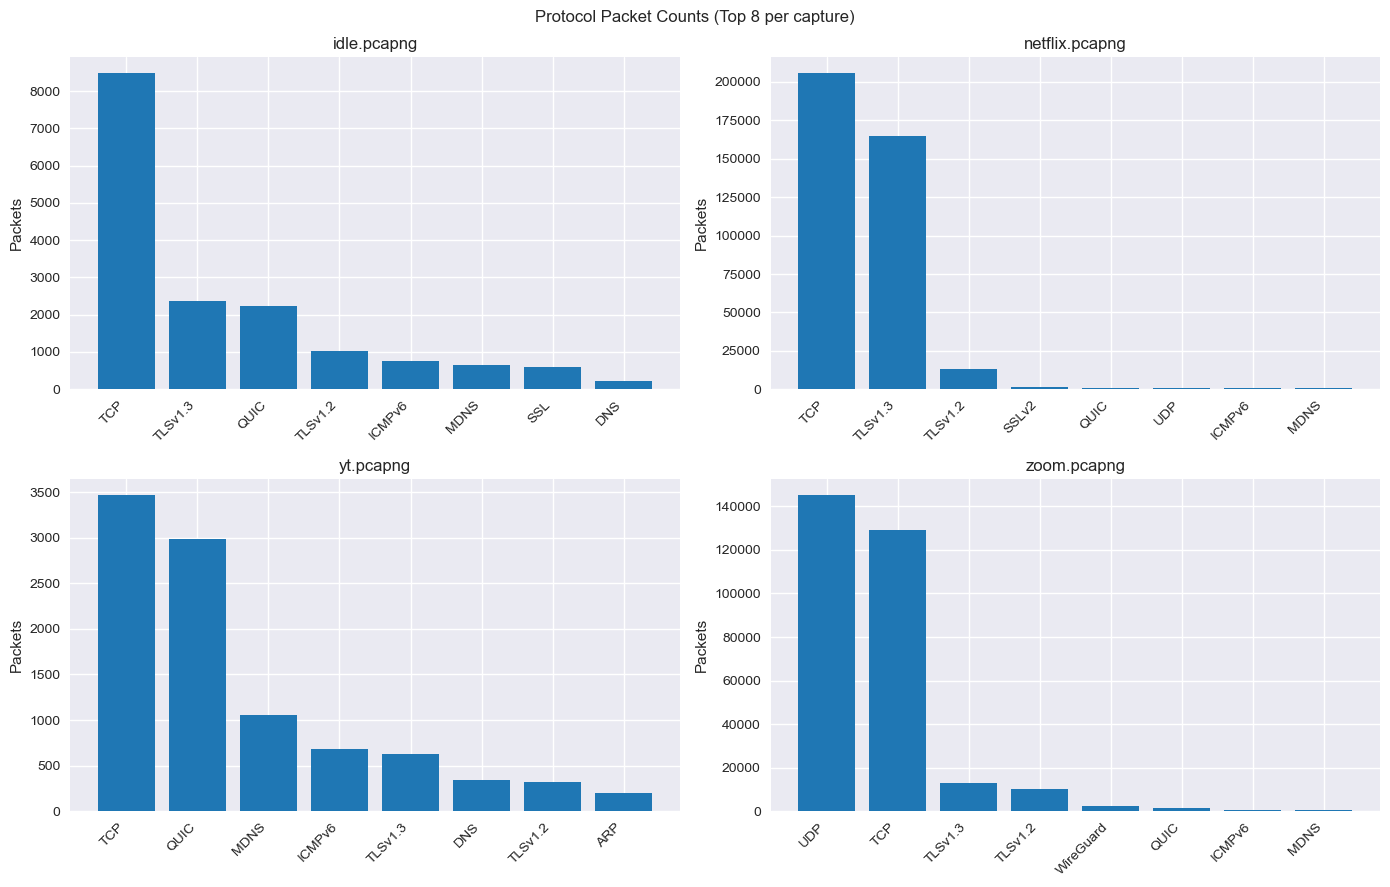

In [5]:

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
for ax, capture_name in zip(axes.flat, capture_order):
    df = protocol_tables.get(capture_name)
    if df is None:
        ax.axis('off')
        continue
    top_df = df.head(8)
    ax.bar(top_df['protocol'], top_df['packets'], color='#1f77b4')
    ax.set_title(capture_name)
    ax.set_ylabel('Packets')
    ax.set_xticklabels(top_df['protocol'], rotation=45, ha='right')
fig.suptitle('Protocol Packet Counts (Top 8 per capture)')
fig.tight_layout()
plt.show()


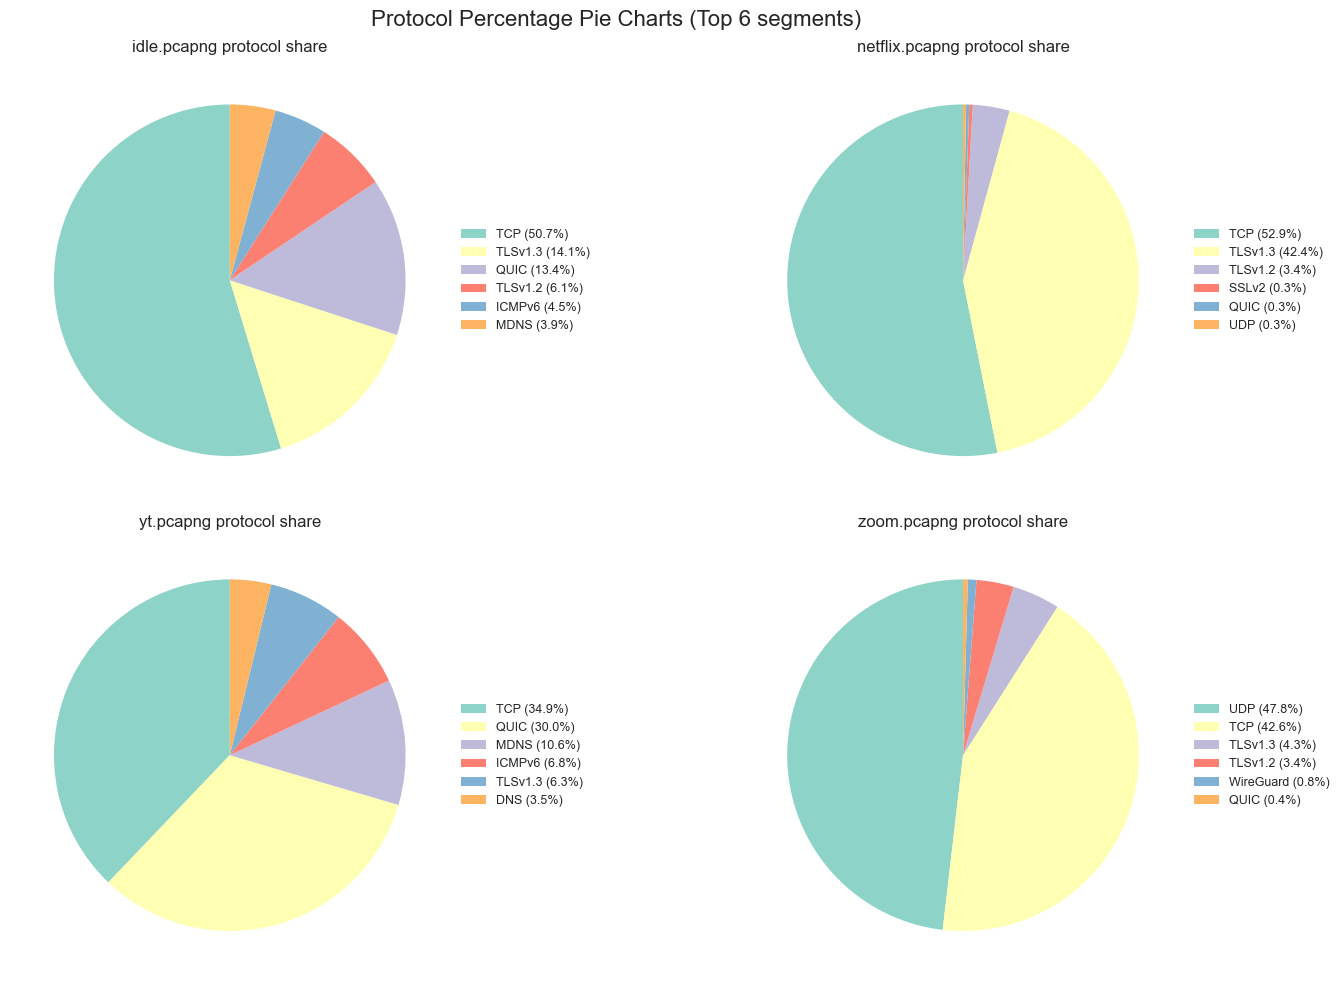

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, capture_name in zip(axes.flat, capture_order):
    df = protocol_tables.get(capture_name)
    if df is None or df.empty:
        ax.axis('off')
        continue
    
    top_df = df.head(6)
    
    # Create labels with percentages for legend
    labels = [f"{row['protocol']} ({row['percentage']:.1f}%)" 
              for _, row in top_df.iterrows()]
    
    # Pie chart without percentage labels
    wedges, texts = ax.pie(
        top_df['percentage'],
        labels=None,  # No labels on pie
        startangle=90,
        colors=plt.cm.Set3.colors[:len(top_df)]
    )
    
    # Add legend instead
    ax.legend(wedges, labels, 
              loc="center left", 
              bbox_to_anchor=(1, 0, 0.5, 1),
              fontsize=9)
    
    ax.set_title(f"{capture_name} protocol share", fontsize=12)
    ax.set_aspect('equal')

fig.subplots_adjust(hspace=0.35, wspace=0.25)
fig.suptitle("Protocol Percentage Pie Charts (Top 6 segments)", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:

proto_commentary = []
for capture_name in capture_order:
    df = protocol_tables.get(capture_name)
    if df is None or df.empty:
        continue
    def pct(protocol):
        match = df[df['protocol'] == protocol]
        return float(match['percentage'].iloc[0]) if not match.empty else 0.0
    tcp_pct = pct('TCP')
    udp_pct = pct('UDP')
    quic_pct = pct('QUIC')
    dns_pct = pct('DNS')
    arp_pct = pct('ARP')
    description = f"**{capture_name}** mixes TCP={tcp_pct:.1f}% / UDP={udp_pct:.1f}% / QUIC={quic_pct:.1f}% with DNS={dns_pct:.1f}% and ARP={arp_pct:.1f}% side-traffic, highlighting its dominant flows."
    if 'idle' in capture_name:
        description += " Idle chatter is mostly ARP/DNS/TLS keep-alives with little UDP beyond multicast discovery."
    elif 'zoom' in capture_name:
        description += " Zoom shows heavy UDP media (port 8801) layered with TLS control traffic, aligning with RTP-like workloads."
    elif 'yt' in capture_name:
        description += " YouTube leans on QUIC over UDP plus sporadic DNS, matching HTTP/3 delivery bursts."
    elif 'netflix' in capture_name:
        description += " Netflix stays TLS/TCP-heavy with relatively fewer DNS queries thanks to cached endpoints."
    proto_commentary.append(description)
display(Markdown("\n\n".join(proto_commentary)))


**idle.pcapng** mixes TCP=50.7% / UDP=0.2% / QUIC=13.4% with DNS=1.3% and ARP=1.0% side-traffic, highlighting its dominant flows. Idle chatter is mostly ARP/DNS/TLS keep-alives with little UDP beyond multicast discovery.

**netflix.pcapng** mixes TCP=52.9% / UDP=0.3% / QUIC=0.3% with DNS=0.1% and ARP=0.0% side-traffic, highlighting its dominant flows. Netflix stays TLS/TCP-heavy with relatively fewer DNS queries thanks to cached endpoints.

**yt.pcapng** mixes TCP=34.9% / UDP=0.5% / QUIC=30.0% with DNS=3.5% and ARP=2.0% side-traffic, highlighting its dominant flows. YouTube leans on QUIC over UDP plus sporadic DNS, matching HTTP/3 delivery bursts.

**zoom.pcapng** mixes TCP=42.6% / UDP=47.8% / QUIC=0.4% with DNS=0.1% and ARP=0.1% side-traffic, highlighting its dominant flows. Zoom shows heavy UDP media (port 8801) layered with TLS control traffic, aligning with RTP-like workloads.


## B. Packet Length Distribution

Histogram (bin=100B) plus probability tables per workload.


In [8]:

length_records = []
binned_records = []
bin_width = 200
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    df = pd.DataFrame(capture.get('packet_length_distribution', []))
    if df.empty:
        continue
    df['capture'] = capture_name
    length_records.append(df)
    df['bin_start'] = (df['start'] // bin_width) * bin_width
    df['bin_end'] = df['bin_start'] + bin_width
    grouped = df.groupby('bin_start')['packets'].sum().reset_index()
    total_packets = grouped['packets'].sum()
    grouped['bin_end'] = grouped['bin_start'] + bin_width
    grouped['capture'] = capture_name
    grouped['percentage'] = grouped['packets'] / total_packets * 100 if total_packets else 0
    grouped['range'] = grouped.apply(lambda row: f"{int(row['bin_start'])}-{int(row['bin_end'])}", axis=1)
    binned_records.append(grouped[['capture', 'bin_start', 'bin_end', 'range', 'percentage']])
length_df = pd.concat(length_records, ignore_index=True)
length_probability_table = pd.concat(binned_records, ignore_index=True)
length_probability_table


,capture,bin_start,bin_end,range,percentage
0,idle.pcapng,0,200,0-200,69.216061
1,idle.pcapng,200,400,200-400,4.648662
2,idle.pcapng,400,600,400-600,6.261950
3,idle.pcapng,600,800,600-800,4.152725
4,idle.pcapng,800,1000,800-1000,0.639340
5,idle.pcapng,1000,1200,1000-1200,3.130975
6,idle.pcapng,1200,1400,1200-1400,9.434751
7,idle.pcapng,1400,1600,1400-1600,2.515535
8,netflix.pcapng,0,200,0-200,13.854870
9,netflix.pcapng,200,400,200-400,0.189796


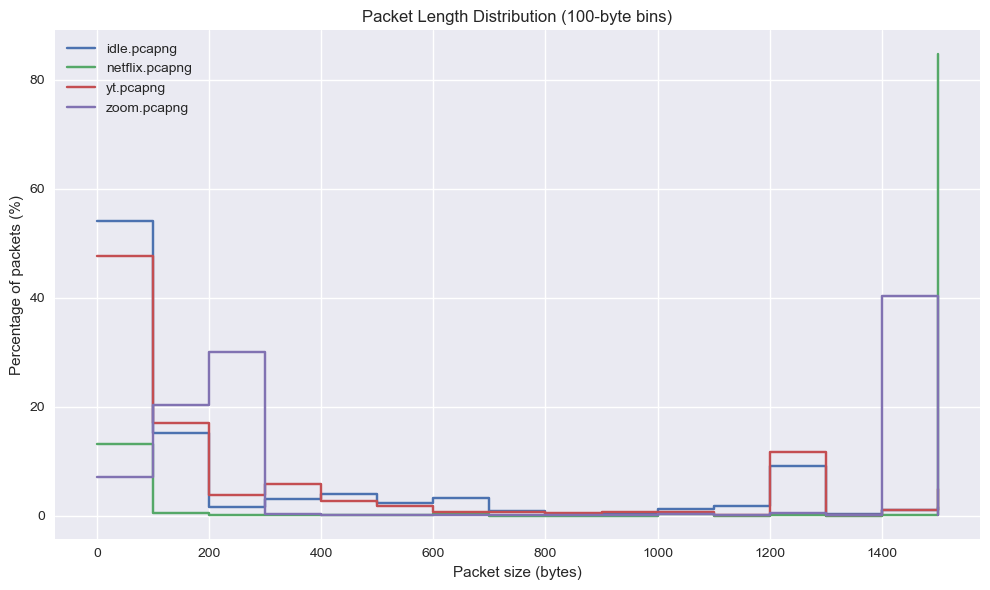

In [9]:

plt.figure(figsize=(10, 6))
for capture_name in capture_order:
    subset = length_df[length_df['capture'] == capture_name]
    if subset.empty:
        continue
    plt.step(subset['start'], subset['percentage'], where='post', label=capture_name)
plt.xlabel('Packet size (bytes)')
plt.ylabel('Percentage of packets (%)')
plt.title('Packet Length Distribution (100-byte bins)')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:

size_commentary = []
for capture_name in capture_order:
    subset = length_probability_table[length_probability_table['capture'] == capture_name]
    if subset.empty:
        continue
    small = subset[subset['bin_end'] <= 200]['percentage'].sum()
    mid = subset[(subset['bin_start'] >= 200) & (subset['bin_end'] <= 800)]['percentage'].sum()
    large_bins = subset[subset['bin_start'] >= 800]['percentage'].sum()
    text = f"**{capture_name}**: {small:.1f}% of packets fall below 200B, {mid:.1f}% between 200-800B, and {large_bins:.1f}% exceed 800B."
    if 'idle' in capture_name:
        text += " Idle traffic concentrates in the <200B region (ARP, ICMP), matching expectations."
    elif 'zoom' in capture_name:
        text += " Zoom media frames cluster between 200-400B, reflecting RTP-sized payloads."
    else:
        text += " Streaming captures push more bytes toward MTU-sized QUIC/TCP frames."
    size_commentary.append(text)
display(Markdown("\n\n".join(size_commentary)))


**idle.pcapng**: 69.2% of packets fall below 200B, 15.1% between 200-800B, and 15.7% exceed 800B. Idle traffic concentrates in the <200B region (ARP, ICMP), matching expectations.

**netflix.pcapng**: 13.9% of packets fall below 200B, 0.7% between 200-800B, and 85.5% exceed 800B. Streaming captures push more bytes toward MTU-sized QUIC/TCP frames.

**yt.pcapng**: 64.7% of packets fall below 200B, 15.5% between 200-800B, and 19.7% exceed 800B. Streaming captures push more bytes toward MTU-sized QUIC/TCP frames.

**zoom.pcapng**: 27.5% of packets fall below 200B, 30.9% between 200-800B, and 41.6% exceed 800B. Zoom media frames cluster between 200-400B, reflecting RTP-sized payloads.


## C. Timing and Traffic Rate Metrics

Per-second packets/sec and throughput traces reveal burstiness vs steady flows.


In [11]:

timeseries_records = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    df = pd.DataFrame(capture.get('per_second_traffic', []))
    if df.empty:
        continue
    df['capture'] = capture_name
    df['time_seconds'] = df['offset_seconds']
    df['time_minutes'] = df['time_seconds'] / 60
    df['packets_per_second'] = df['packets']
    df['throughput_bps'] = df['bytes'] * 8
    timeseries_records.append(df)
time_series_df = pd.concat(timeseries_records, ignore_index=True)
time_series_df.head()


,second_epoch,offset_seconds,packets,bytes,capture,time_seconds,time_minutes,packets_per_second,throughput_bps
0,1764165522,0,14,1264,idle.pcapng,0,0.000000,14,10112
1,1764165523,1,0,0,idle.pcapng,1,0.016667,0,0
2,1764165524,2,0,0,idle.pcapng,2,0.033333,0,0
3,1764165525,3,0,0,idle.pcapng,3,0.050000,0,0
4,1764165526,4,52,6332,idle.pcapng,4,0.066667,52,50656


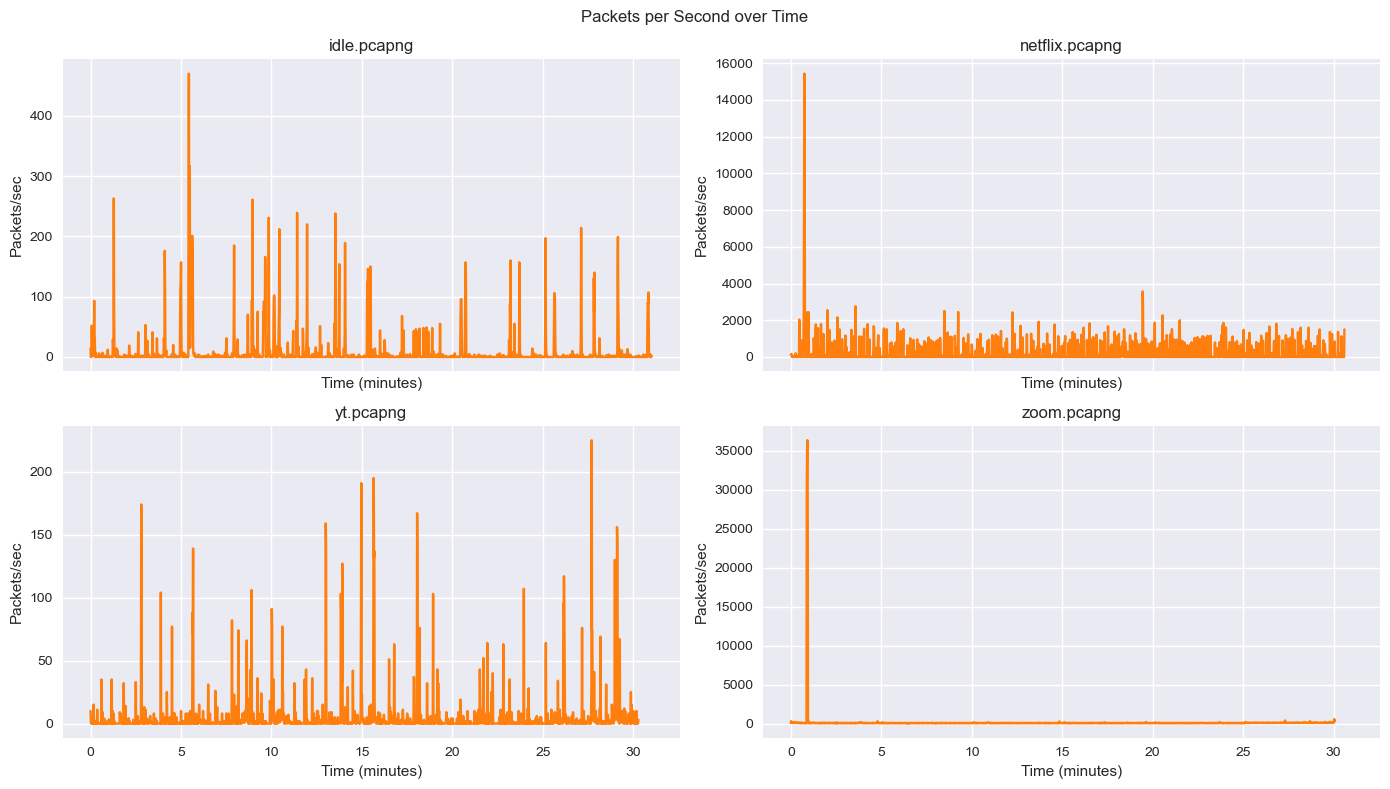

In [12]:

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
for ax, capture_name in zip(axes.flat, capture_order):
    subset = time_series_df[time_series_df['capture'] == capture_name]
    if subset.empty:
        ax.axis('off')
        continue
    ax.plot(subset['time_minutes'], subset['packets_per_second'], label='pps', color='#ff7f0e')
    ax.set_title(capture_name)
    ax.set_ylabel('Packets/sec')
    ax.set_xlabel('Time (minutes)')
fig.suptitle('Packets per Second over Time')
fig.tight_layout()
plt.show()


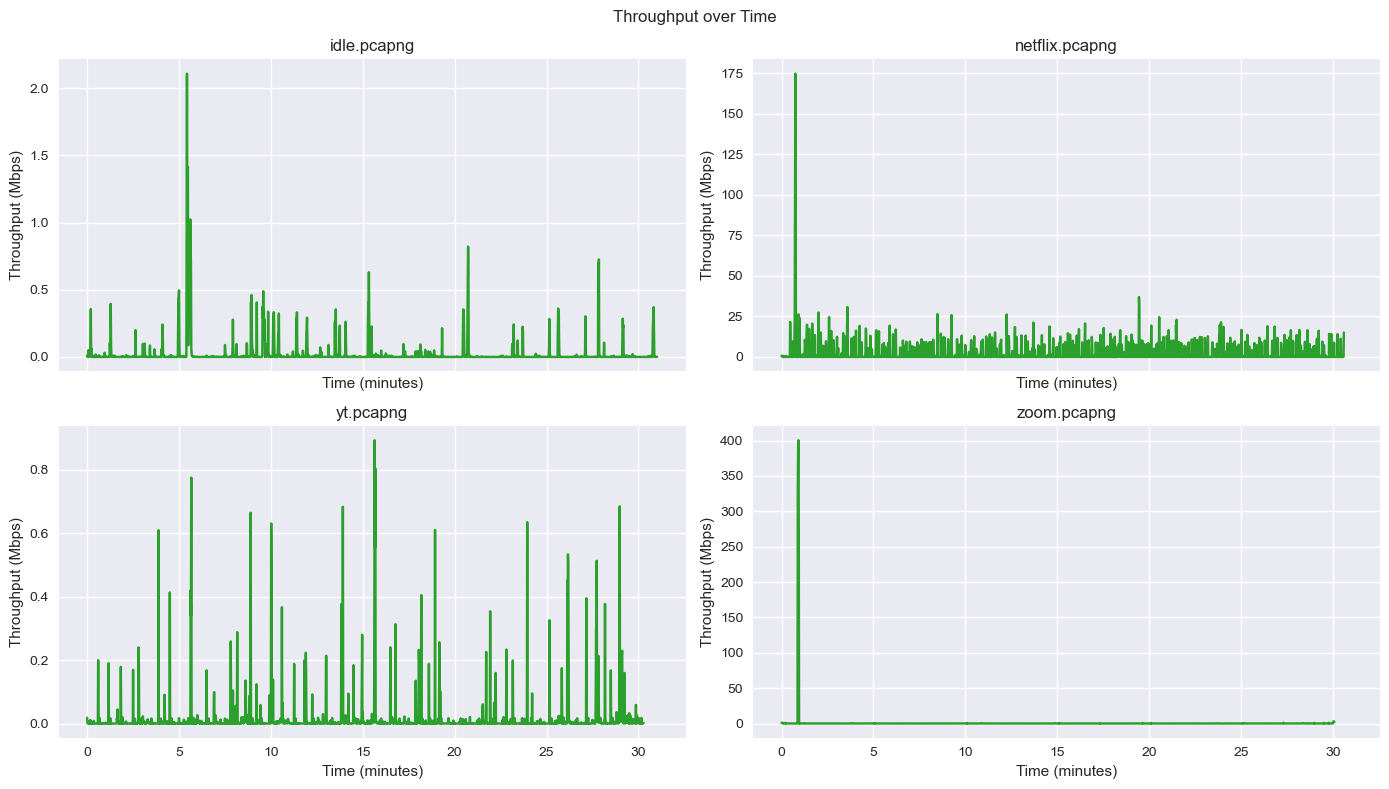

In [13]:

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
for ax, capture_name in zip(axes.flat, capture_order):
    subset = time_series_df[time_series_df['capture'] == capture_name]
    if subset.empty:
        ax.axis('off')
        continue
    ax.plot(subset['time_minutes'], subset['throughput_bps'] / 1e6, color='#2ca02c')
    ax.set_title(capture_name)
    ax.set_ylabel('Throughput (Mbps)')
    ax.set_xlabel('Time (minutes)')
fig.suptitle('Throughput over Time')
fig.tight_layout()
plt.show()


In [14]:

timing_notes = []
stats = time_series_df.groupby('capture').agg(
    pps_mean=('packets_per_second', 'mean'),
    pps_peak=('packets_per_second', 'max'),
    bps_mean=('throughput_bps', 'mean'),
    bps_peak=('throughput_bps', 'max'),
)
for capture_name, row in stats.iterrows():
    text = (
        f"**{capture_name}** averages {row.pps_mean:.1f} pps (peak {row.pps_peak:.1f}) "
        f"and {row.bps_mean/1e6:.3f} Mbps throughput (peak {row.bps_peak/1e6:.3f} Mbps)."
    )
    if 'zoom' in capture_name:
        text += " Zoom spikes up to the mid-0.9 Mbps range as media bursts arrive, yet remains steadier than YouTube."
    elif 'yt' in capture_name:
        text += " YouTube swings between quiet periods and sharp bursts, consistent with adaptive buffering."
    elif 'netflix' in capture_name:
        text += " Netflix stays smooth with sustained Mbps-level throughput thanks to aggressive pre-buffering."
    else:
        text += " Idle trace barely registers above noise, aside from periodic ARP/DNS refresh spikes."
    timing_notes.append(text)
display(Markdown("\n\n".join(timing_notes)))


**idle.pcapng** averages 9.0 pps (peak 470.0) and 0.024 Mbps throughput (peak 2.109 Mbps). Idle trace barely registers above noise, aside from periodic ARP/DNS refresh spikes.

**netflix.pcapng** averages 211.7 pps (peak 15429.0) and 2.215 Mbps throughput (peak 174.834 Mbps). Netflix stays smooth with sustained Mbps-level throughput thanks to aggressive pre-buffering.

**yt.pcapng** averages 5.5 pps (peak 225.0) and 0.017 Mbps throughput (peak 0.893 Mbps). YouTube swings between quiet periods and sharp bursts, consistent with adaptive buffering.

**zoom.pcapng** averages 167.9 pps (peak 36350.0) and 0.945 Mbps throughput (peak 400.468 Mbps). Zoom spikes up to the mid-0.9 Mbps range as media bursts arrive, yet remains steadier than YouTube.


## D. TCP / UDP / QUIC Behavior

Connection health, transport flags, UDP usage, and QUIC packet types.


In [15]:

tcp_udp_rows = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    rtt_stats = capture.get('tcp_rtt_stats', {})
    udp_total = capture.get('udp_total_bytes', 0)
    tcp_udp_rows.append(
        {
            'capture': capture_name,
            'tcp_connections': capture.get('tcp_connection_count', 0),
            'syn': capture.get('tcp_syn_packets', 0),
            'syn_ack': capture.get('tcp_synack_packets', 0),
            'fin': capture.get('tcp_fin_packets', 0),
            'rst': capture.get('tcp_rst_packets', 0),
            'tcp_rtt_avg_ms': (rtt_stats.get('average') or 0) * 1000,
            'tcp_rtt_max_ms': (rtt_stats.get('max') or 0) * 1000,
            'udp_packets': capture.get('udp_packet_count', 0),
            'udp_bytes': udp_total,
            'udp_share_pct': (capture.get('udp_packet_count', 0) / capture.get('packet_count', 1)) * 100,
        }
    )
tcp_udp_df = pd.DataFrame(tcp_udp_rows).set_index('capture')
tcp_udp_df


,tcp_connections,syn,syn_ack,fin,rst,tcp_rtt_avg_ms,tcp_rtt_max_ms,udp_packets,udp_bytes,udp_share_pct
capture,,,,,,,,,,
idle.pcapng,373,743,376,605,252,11.767130,119.385,3426,1996290,20.470841
netflix.pcapng,209,391,197,260,170,2.066554,759.419,3167,1144819,0.814478
yt.pcapng,146,279,140,251,110,12.070630,872.762,4549,2165137,45.778404
zoom.pcapng,163,274,137,293,147,15.154404,2217.113,149785,32886134,49.384934


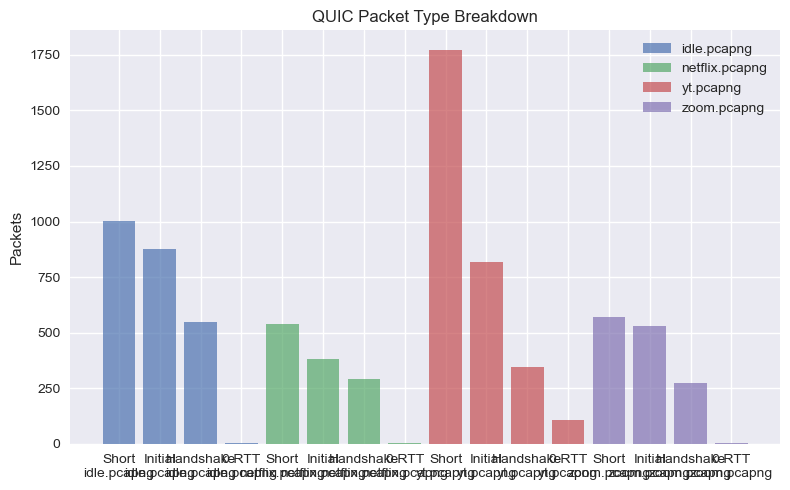

In [16]:

quic_records = []
for capture_name in capture_order:
    for entry in capture_frames[capture_name].get('quic_packet_types', []):
        quic_records.append({
            'capture': capture_name,
            'packet_type': entry['packet_type'],
            'packets': entry['packets'],
        })
quic_df = pd.DataFrame(quic_records)
if not quic_df.empty:
    fig, ax = plt.subplots(figsize=(8, 5))
    for capture_name in quic_df['capture'].unique():
        subset = quic_df[quic_df['capture'] == capture_name]
        ax.bar(
            subset['packet_type'] + f"\n{capture_name}",
            subset['packets'],
            label=capture_name,
            alpha=0.7,
        )
    ax.set_ylabel('Packets')
    ax.set_title('QUIC Packet Type Breakdown')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No QUIC dissection available in these traces.')


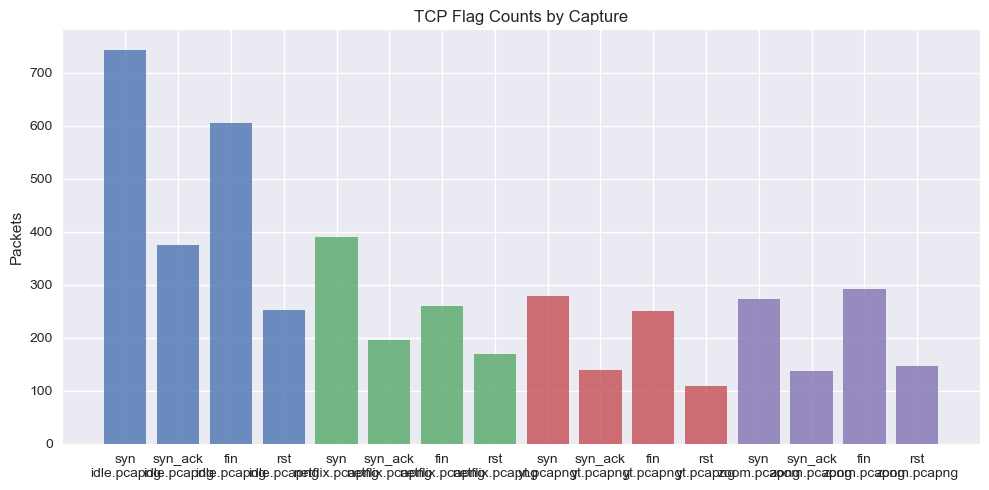

In [17]:

flag_metrics = tcp_udp_df[['syn', 'syn_ack', 'fin', 'rst']].reset_index().melt(id_vars='capture', var_name='flag', value_name='packets')
fig, ax = plt.subplots(figsize=(10, 5))
for capture_name in capture_order:
    subset = flag_metrics[flag_metrics['capture'] == capture_name]
    ax.bar(subset['flag'] + f"\n{capture_name}", subset['packets'], alpha=0.8)
ax.set_ylabel('Packets')
ax.set_title('TCP Flag Counts by Capture')
plt.tight_layout()
plt.show()


In [18]:

transport_notes = []
for capture_name in capture_order:
    row = tcp_udp_df.loc[capture_name]
    text = (
        f"**{capture_name}** observed {row.tcp_connections} TCP connections with "
        f"avg RTT {row.tcp_rtt_avg_ms:.1f} ms (max {row.tcp_rtt_max_ms:.1f} ms) and {row.udp_share_pct:.1f}% UDP share."
    )
    if 'zoom' in capture_name:
        text += " UDP dominates (~50%+) via ports 8801/59529 for RTP media, while TCP handshakes remain minimal."
    elif 'netflix' in capture_name:
        text += " Netflix keeps long-lived TLS/TCP flows alive with low SYN/RST churn, consistent with buffered streaming."
    elif 'yt' in capture_name:
        text += " YouTube mixes QUIC Initial/Handshake packets with later short-header traffic, highlighting HTTP/3 use."
    else:
        text += " Idle trace shows mostly short TCP keep-alives and sparse UDP."
    transport_notes.append(text)
display(Markdown("\n\n".join(transport_notes)))


**idle.pcapng** observed 373.0 TCP connections with avg RTT 11.8 ms (max 119.4 ms) and 20.5% UDP share. Idle trace shows mostly short TCP keep-alives and sparse UDP.

**netflix.pcapng** observed 209.0 TCP connections with avg RTT 2.1 ms (max 759.4 ms) and 0.8% UDP share. Netflix keeps long-lived TLS/TCP flows alive with low SYN/RST churn, consistent with buffered streaming.

**yt.pcapng** observed 146.0 TCP connections with avg RTT 12.1 ms (max 872.8 ms) and 45.8% UDP share. YouTube mixes QUIC Initial/Handshake packets with later short-header traffic, highlighting HTTP/3 use.

**zoom.pcapng** observed 163.0 TCP connections with avg RTT 15.2 ms (max 2217.1 ms) and 49.4% UDP share. UDP dominates (~50%+) via ports 8801/59529 for RTP media, while TCP handshakes remain minimal.


## E. ARP & ICMP Message Analysis

Request/reply counts, intervals, and ICMP control traffic.


In [19]:

arp_rows = []
icmp_rows = []
arp_timeline_records = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    arp_summary = capture.get('arp_summary', {})
    interval_stats = arp_summary.get('request_interval_stats', {})
    arp_rows.append(
        {
            'capture': capture_name,
            'arp_requests': arp_summary.get('request_count', 0),
            'arp_replies': arp_summary.get('reply_count', 0),
            'avg_request_interval_s': interval_stats.get('average'),
        }
    )
    icmp_df = pd.DataFrame(capture.get('icmp_messages', []))
    if not icmp_df.empty:
        icmp_df['capture'] = capture_name
        icmp_rows.append(icmp_df)
    event_df = pd.DataFrame(capture.get('arp_events', []))
    if not event_df.empty:
        event_df['capture'] = capture_name
        event_df['offset_seconds'] = event_df['offset_seconds'].fillna(0)
        event_df['minute'] = (event_df['offset_seconds'] // 60).astype(int)
        counts = event_df.groupby(['capture', 'minute', 'opcode']).size().reset_index(name='events')
        arp_timeline_records.append(counts)
arp_df = pd.DataFrame(arp_rows).set_index('capture')
icmp_df = pd.concat(icmp_rows, ignore_index=True) if icmp_rows else pd.DataFrame()
arp_df


,arp_requests,arp_replies,avg_request_interval_s
capture,,,
idle.pcapng,79,89,23.690696
netflix.pcapng,77,80,22.823084
yt.pcapng,96,101,18.610331
zoom.pcapng,109,113,16.546008


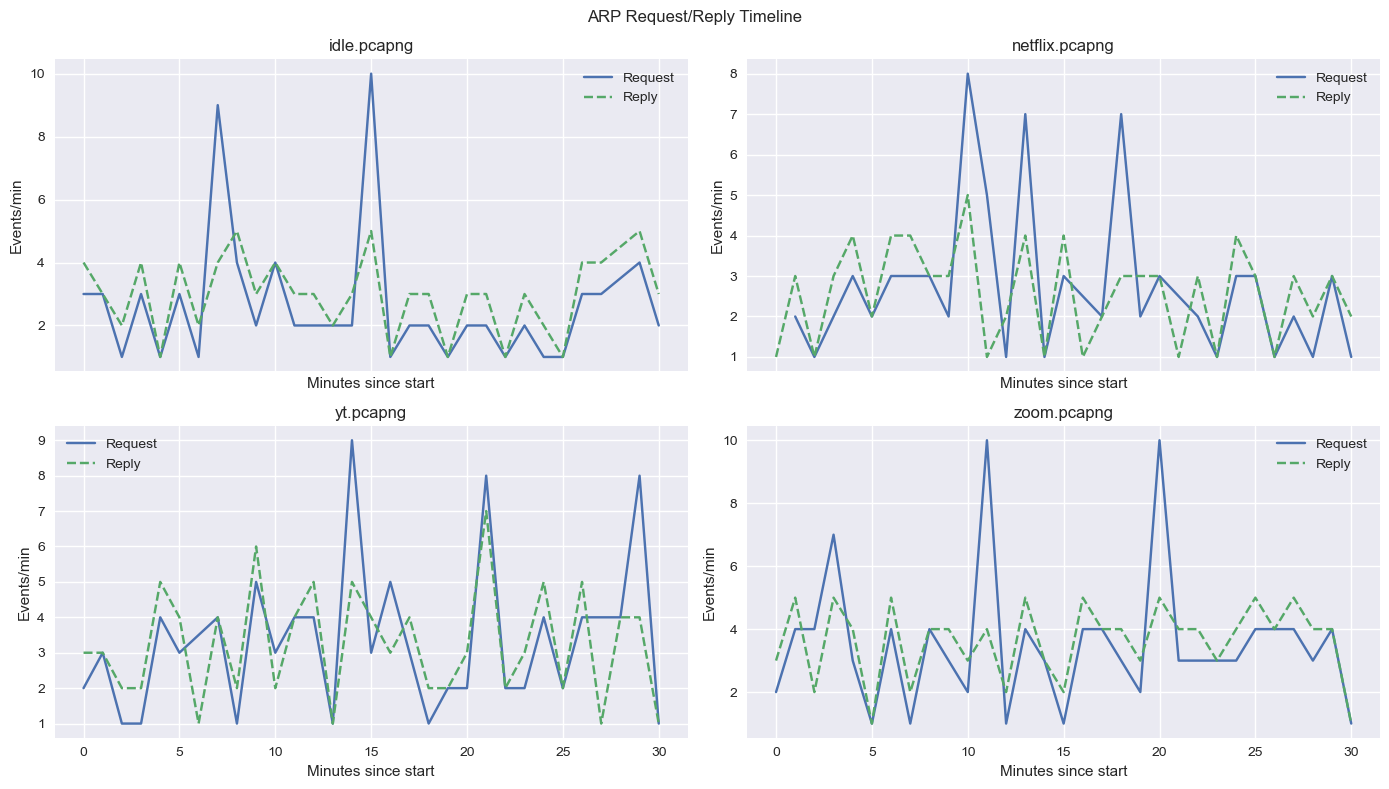

In [20]:

if arp_timeline_records:
    timeline_df = pd.concat(arp_timeline_records, ignore_index=True)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
    for ax, capture_name in zip(axes.flat, capture_order):
        subset = timeline_df[timeline_df['capture'] == capture_name]
        if subset.empty:
            ax.axis('off')
            continue
        for opcode, style in [('request', '-'), ('reply', '--')]:
            op_df = subset[subset['opcode'] == opcode]
            ax.plot(op_df['minute'], op_df['events'], linestyle=style, label=opcode.capitalize())
        ax.set_title(capture_name)
        ax.set_ylabel('Events/min')
        ax.set_xlabel('Minutes since start')
        ax.legend()
    fig.suptitle('ARP Request/Reply Timeline')
    fig.tight_layout()
    plt.show()
else:
    print('No ARP events captured.')


In [21]:

arp_notes = []
for capture_name in capture_order:
    row = arp_df.loc[capture_name]
    text = f"**{capture_name}**: {row.arp_requests} ARP requests / {row.arp_replies} replies with average refresh interval {row.avg_request_interval_s or 0:.1f}s."
    if 'idle' in capture_name:
        text += " Idle state sees timer-driven refreshes roughly every 30s."
    elif 'zoom' in capture_name:
        text += " Zoom maintains current neighbor cache with sporadic requests despite high data volume."
    else:
        text += " Streaming traces issue occasional bursts when interfaces transition between Wi-Fi/APNs."
    arp_notes.append(text)
icmp_summary = []
if not icmp_df.empty:
    icmp_counts = icmp_df.groupby(['capture', 'type', 'code'])['packets'].sum().reset_index()
    for capture_name in capture_order:
        subset = icmp_counts[icmp_counts['capture'] == capture_name]
        if subset.empty:
            continue
        lines = ", ".join(
            f"type {row['type']}/code {row['code']} ({row['packets']} pkt)" for _, row in subset.iterrows()
        )
        icmp_summary.append(f"{capture_name}: {lines}")
display(Markdown("\n\n".join(arp_notes + icmp_summary)))


**idle.pcapng**: 79.0 ARP requests / 89.0 replies with average refresh interval 23.7s. Idle state sees timer-driven refreshes roughly every 30s.

**netflix.pcapng**: 77.0 ARP requests / 80.0 replies with average refresh interval 22.8s. Streaming traces issue occasional bursts when interfaces transition between Wi-Fi/APNs.

**yt.pcapng**: 96.0 ARP requests / 101.0 replies with average refresh interval 18.6s. Streaming traces issue occasional bursts when interfaces transition between Wi-Fi/APNs.

**zoom.pcapng**: 109.0 ARP requests / 113.0 replies with average refresh interval 16.5s. Zoom maintains current neighbor cache with sporadic requests despite high data volume.

idle.pcapng: type 3/code 3 (27 pkt)

netflix.pcapng: type 3/code 3 (14 pkt)

yt.pcapng: type 0/code 0 (16 pkt), type 3/code 3 (6 pkt), type 8/code 0 (16 pkt)

zoom.pcapng: type 3/code 3 (15 pkt)


## F. Delay / Response Time Analysis

DNS request → response latency statistics.


In [22]:

dns_rows = []
dns_time_records = []
for capture_name in capture_order:
    capture = capture_frames[capture_name]
    stats = capture.get('dns_response_time_stats', {})
    dns_rows.append(
        {
            'capture': capture_name,
            'samples': stats.get('count', 0),
            'avg_ms': (stats.get('average') or 0) * 1000,
            'min_ms': (stats.get('min') or 0) * 1000,
            'max_ms': (stats.get('max') or 0) * 1000,
        }
    )
    times = capture.get('dns_response_times', [])
    if times:
        dns_time_records.extend([
            {'capture': capture_name, 'latency_ms': value * 1000} for value in times
        ])
dns_df = pd.DataFrame(dns_rows).set_index('capture')
dns_times_df = pd.DataFrame(dns_time_records)
dns_df


,samples,avg_ms,min_ms,max_ms
capture,,,,
idle.pcapng,229,2547.122410,0.005,156461.974
netflix.pcapng,219,2186.375667,0.301,246686.831
yt.pcapng,382,1144.790746,0.001,69429.381
zoom.pcapng,226,1974.004305,0.452,243918.339


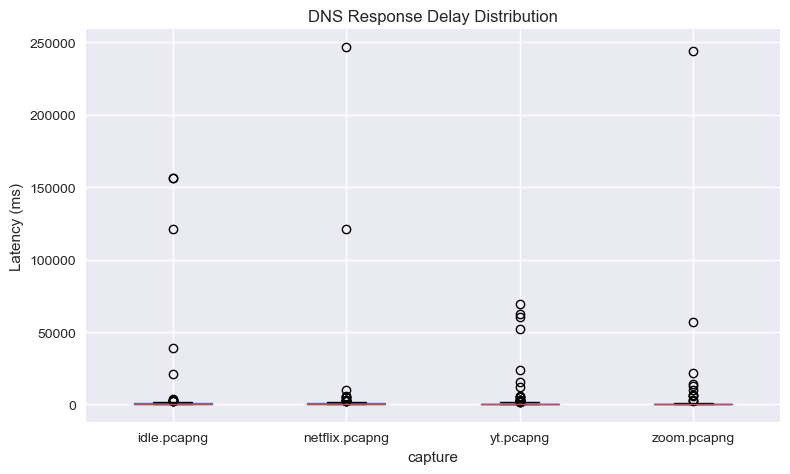

In [23]:

if not dns_times_df.empty:
    fig, ax = plt.subplots(figsize=(8, 5))
    dns_times_df.boxplot(column='latency_ms', by='capture', ax=ax)
    ax.set_ylabel('Latency (ms)')
    ax.set_title('DNS Response Delay Distribution')
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
else:
    print('No DNS timings found in these traces.')



## Cross-Workload Comparisons & Takeaways

Insights highlighting streaming vs interactive vs idle behaviors.


In [24]:

comparison_points = []
streaming = summary_df.loc[['yt.pcapng', 'netflix.pcapng']]
zoom = summary_df.loc['zoom.pcapng']
idle = summary_df.loc['idle.pcapng']
comparison_points.append(
    f"1. **Streaming vs Interactive**: YouTube ({streaming.loc['yt.pcapng', 'throughput_bps_avg']/1e6:.2f} Mbps avg) "
    f"and Netflix ({streaming.loc['netflix.pcapng', 'throughput_bps_avg']/1e6:.2f} Mbps) sustain high throughput at modest pps, whereas Zoom ({zoom['throughput_bps_avg']/1e6:.2f} Mbps) keeps lower bandwidth but higher packet rates for real-time media."
)
comparison_points.append(
    f"2. **Idle vs Active**: Idle background stays <{idle['throughput_bps_avg']/1e3:.1f} Kbps with ARP/DNS bursts, while active traces maintain continuous TLS/UDP flows."
)
comparison_points.append(
    f"3. **TCP vs UDP usage**: Zoom allocates {zoom['udp_share_pct']:.1f}% of packets to UDP (RTP/QUIC), yet Netflix remains {streaming.loc['netflix.pcapng', 'udp_share_pct']:.1f}% UDP with TLS/TCP dominating."
)
comparison_points.append(
    "4. **Packet sizes**: Idle has most packets below 200B, Zoom centers between 200-400B, and streaming traces push sizeable MTU-length frames."
)
display(Markdown("\n\n".join(comparison_points)))


1. **Streaming vs Interactive**: YouTube (0.02 Mbps avg) and Netflix (2.22 Mbps) sustain high throughput at modest pps, whereas Zoom (0.94 Mbps) keeps lower bandwidth but higher packet rates for real-time media.

2. **Idle vs Active**: Idle background stays <24.1 Kbps with ARP/DNS bursts, while active traces maintain continuous TLS/UDP flows.

3. **TCP vs UDP usage**: Zoom allocates 49.4% of packets to UDP (RTP/QUIC), yet Netflix remains 0.8% UDP with TLS/TCP dominating.

4. **Packet sizes**: Idle has most packets below 200B, Zoom centers between 200-400B, and streaming traces push sizeable MTU-length frames.


## Figures Rendered

1. Protocol packet-count bar grid
2. Protocol percentage pie grid
3. Packet length distribution histogram
4. Packets-per-second over time (per capture)
5. Throughput vs time (per capture)
6. DNS response delay distribution
7. ARP request/reply timeline
8. QUIC packet type breakdown
9. TCP flag frequency bars
